In [0]:
import numpy as np
import pandas as pd
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
import random, math, os, time

In [0]:
SEED = 1234
random.seed(SEED)

In [0]:
import matplotlib.pyplot as plt


In [0]:
filepath = 'https://raw.githubusercontent.com/vishal-pandey/SSIM/master/SSIM/data/simplified_PM25.csv'
df = pd.read_csv(filepath, dayfirst=True)

In [0]:
train_sampling_params = {
    'dim_in': 11,
    'output_length': 5,
    'min_before': 20,
    'max_before': 25,
    'min_after': 20,
    'max_after': 25,
}

In [0]:
test_sampling_params = {
  'dim_in': 11,
  'output_length': 5,
  'min_before': 20,
  'max_before': 25,
  'min_after': 20,
  'max_after': 25,
}

In [7]:
df.head()

,date,pm2.5,DEWP,TEMP,PRES,Iws,Is,Ir,winddirect_0,winddirect_1,winddirect_2,winddirect_3
0,2/01/2010 0:00,129,-16,-4.0,1020.0,1.79,0,0,0,0,1,0
1,2/01/2010 1:00,148,-15,-4.0,1020.0,2.68,0,0,0,0,1,0
2,2/01/2010 2:00,159,-11,-5.0,1021.0,3.57,0,0,0,0,1,0
3,2/01/2010 3:00,181,-7,-5.0,1022.0,5.36,1,0,0,0,1,0
4,2/01/2010 4:00,138,-7,-5.0,1022.0,6.25,2,0,0,0,1,0


In [0]:
len(df[:5000])
df = df[:5000]

In [9]:
df.iloc[0, 1]

129

In [10]:
print(df.iloc[0, 0])
print(df.iloc[4000, 0])
print(df.iloc[4001, 0])
print(df.iloc[4999, 0])


df.set_index('date', inplace=True)

2/01/2010 0:00
17/06/2010 16:00
17/06/2010 17:00
29/07/2010 7:00


In [11]:
df.head()

,pm2.5,DEWP,TEMP,PRES,Iws,Is,Ir,winddirect_0,winddirect_1,winddirect_2,winddirect_3
date,,,,,,,,,,,
2/01/2010 0:00,129,-16,-4.0,1020.0,1.79,0,0,0,0,1,0
2/01/2010 1:00,148,-15,-4.0,1020.0,2.68,0,0,0,0,1,0
2/01/2010 2:00,159,-11,-5.0,1021.0,3.57,0,0,0,0,1,0
2/01/2010 3:00,181,-7,-5.0,1022.0,5.36,1,0,0,0,1,0
2/01/2010 4:00,138,-7,-5.0,1022.0,6.25,2,0,0,0,1,0


In [0]:
pm25 = df['pm2.5'].values.copy().reshape(-1, 1)

In [13]:
scaler_x = StandardScaler()
scaler_x.fit(df[['pm2.5', 'DEWP', 'TEMP', 'PRES', 'Iws', 'Is', 'Ir']])

StandardScaler(copy=True, with_mean=True, with_std=True)

In [0]:
df[['pm2.5', 'DEWP', 'TEMP', 'PRES', 'Iws', 'Is', 'Ir']] = scaler_x.transform(df[['pm2.5', 'DEWP', 'TEMP', 'PRES', 'Iws', 'Is', 'Ir']])

In [0]:
scaler_y = StandardScaler()
scaler_y.fit(pm25)
y_all = scaler_y.transform(pm25)

In [0]:
df_train = df.loc['2/01/2010 0:00': '17/06/2010 16:00'].copy()
df_test = df.loc['17/06/2010 17:00': '29/07/2010 7:00'].copy()

In [0]:
y = y_all

In [0]:
def train_val_test_generate(dataframe, model_params):
    '''
    :param dataframe: processed dataframe
    :param model_params: for input dim
    :return: train_x, train_y, test_x, test_y with the same length (by padding zero)
    '''

    train_val_test_x, train_val_test_y, len_x_samples, len_before_x_samples = pad_all_cases(dataframe,
                                                                                            dataframe['pm2.5'].values,
                                                                                            model_params,
                                                                                            model_params['min_before'],
                                                                                            model_params['max_before'],
                                                                                            model_params['min_after'],
                                                                                            model_params['max_after'],
                                                                                            model_params[
                                                                                                'output_length'])

    train_val_test_y = np.expand_dims(train_val_test_y, axis=2)

    return train_val_test_x, train_val_test_y, len_x_samples, len_before_x_samples

In [0]:

def generate_samples(x, y, model_params, seq_len_before=7, seq_len_after=7, output_seq_len=9):
    """
    Generate samples, input past and future, target middle
    :param x: input dataframe
    :param y: target variable to impute
    :param seq_len_before:
    :param seq_len_after:
    :param output_seq_len:
    :return: (inputsequence, targetsequence)
    """
    total_samples = x.shape[0]
    total_len = seq_len_before + seq_len_after + output_seq_len

    input_batch_idxs = [list(range(i, i + seq_len_before)) + list(
        range(i + seq_len_before + output_seq_len, i + seq_len_before + output_seq_len + seq_len_after)) for i in
                        range((total_samples - total_len + 1))]

    input_seq = np.take(x, input_batch_idxs, axis=0)

    z = np.zeros((output_seq_len, model_params['dim_in']))

    input_seq = np.array([np.concatenate((i[:seq_len_before], z, i[seq_len_before:])) for i in input_seq])

    output_batch_idxs = [list(range(i + seq_len_before, i + seq_len_before + output_seq_len)) for i in
                         range((total_samples - total_len + 1))]

    output_seq = np.take(y, output_batch_idxs, axis=0)

    return input_seq, output_seq


def pad_all_cases(x, y, model_params, min_len_before=7, max_len_before=9, min_len_after=7, max_len_after=9,
                  targetlength=9):
    """
    variable length inputs, fix length outputs
    :param x: input dataframe
    :param y: target variable to impute
    :param min_len_before:
    :param max_len_before:
    :param min_len_after:
    :param max_len_after:
    :param targetlength:
    :return: inputsequence with same length, outputsequence with same length
    """
    total_x = []
    total_y = []
    total_len_x = []
    totle_len_before_x = []

    for l_before in range(min_len_before, max_len_before + 1):
        for l_after in range(min_len_after, max_len_after + 1):
            case_x, case_y = generate_samples(x.values, y, model_params, l_before, l_after, targetlength)
            # npad is a tuple of (n_before, n_after) for each dimension

            len_x = np.full(case_x.shape[0], case_x.shape[1])
            len_before_sequence_x = np.full(case_x.shape[0], l_before)

            npad = ((0, 0), (0, max_len_before - l_before + max_len_after - l_after), (0, 0))

            same_length_x = np.pad(case_x, pad_width=npad, mode='constant', constant_values=0)

            total_x.append(same_length_x)
            total_y.append(case_y)
            total_len_x.append(len_x)
            totle_len_before_x.append(len_before_sequence_x)

    ## total x,y
    concatenated_x = np.concatenate(total_x, axis=0)
    concatenated_y = np.concatenate(total_y, axis=0)
    len_all_case = np.concatenate(total_len_x).ravel()
    len_before_all_case = np.concatenate(totle_len_before_x).ravel()

    return concatenated_x, concatenated_y, len_all_case, len_before_all_case

In [0]:
# x_samples, y_samples, x_len, x_before_len = train_val_test_generate(df_train, train_sampling_params)
# def train_val_test_generate(dataframe, model_params):

dataframe = df_train
dataframe1 = df_test
model_params = train_sampling_params



In [0]:
x = dataframe
x1 = dataframe1
y = dataframe['pm2.5'].values
y1 = dataframe1['pm2.5'].values
# model_params = model_params
min_len_before = model_params['min_before']
max_len_before = model_params['max_before']
min_len_after = model_params['min_after'] 
max_len_after = model_params['max_after']
targetlength = model_params['output_length']

In [0]:
total_x = []
total_y = []
total_len_x = []
total_len_before_x = []

In [0]:
def generate_samples(x, y, model_params, seq_len_before=7, seq_len_after=7, output_seq_len=9):
    """
    Generate samples, input past and future, target middle
    :param x: input dataframe
    :param y: target variable to impute
    :param seq_len_before:
    :param seq_len_after:
    :param output_seq_len:
    :return: (inputsequence, targetsequence)
    """
    total_samples = x.shape[0]
    total_len = seq_len_before + seq_len_after + output_seq_len

    input_batch_idxs = [list(range(i, i + seq_len_before)) + list(
        range(i + seq_len_before + output_seq_len, i + seq_len_before + output_seq_len + seq_len_after)) for i in
                        range((total_samples - total_len + 1))]

    input_seq = np.take(x, input_batch_idxs, axis=0)

    z = np.zeros((output_seq_len, model_params['dim_in']))

    input_seq = np.array([np.concatenate((i[:seq_len_before], z, i[seq_len_before:])) for i in input_seq])

    output_batch_idxs = [list(range(i + seq_len_before, i + seq_len_before + output_seq_len)) for i in
                         range((total_samples - total_len + 1))]

    output_seq = np.take(y, output_batch_idxs, axis=0)

    return input_seq, output_seq

In [0]:
def train_test_split_SSIM(x, y, x_len, x_before_len, model_params, SEED):
    '''
    :param x: all x samples
    :param y: all y samples
    :param model_params: parameters
    :param SEED: random SEED
    :return: train set, test set
    '''

    ## check and remove samples with NaN (just incase)
    index_list = []
    for index, (x_s, y_s, len_s, len_before_s) in enumerate(zip(x, y, x_len, x_before_len)):
        if (np.isnan(x_s).any()) or (np.isnan(y_s).any()):
            index_list.append(index)

    x = np.delete(x, index_list, axis=0)
    y = np.delete(y, index_list, axis=0)
    x_len = np.delete(x_len, index_list, axis=0)
    x_before_len = np.delete(x_before_len, index_list, axis=0)

    x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=None,
                                                        random_state=SEED,
                                                        shuffle=False)

    x_train_len, x_test_len = train_test_split(x_len, test_size=None, random_state=SEED, shuffle=False)

    x_train_before_len, x_test_before_len = train_test_split(x_before_len, test_size=None, random_state=SEED,
                                                             shuffle=False)

    return x_train, y_train, x_train_len, x_train_before_len

In [0]:
for l_before in range(min_len_before, max_len_before+1):
  for l_after in range(min_len_after, max_len_after+1):
    case_x, case_y = generate_samples(x.values, y, model_params, l_before, l_after, targetlength)
    
    len_x = np.full(case_x.shape[0], case_x.shape[1])
    len_before_sequence_x = np.full(case_x.shape[0], l_before)

    npad = ((0, 0), (0, max_len_before - l_before + max_len_after - l_after), (0, 0))

    same_length_x = np.pad(case_x, pad_width=npad, mode='constant', constant_values=0)

    total_x.append(same_length_x)

    total_y.append(case_y)

    total_len_x.append(len_x)

    total_len_before_x.append(len_before_sequence_x)

concatenated_x = np.concatenate(total_x, axis=0)
concatenated_y = np.concatenate(total_y, axis=0)
len_all_case = np.concatenate(total_len_x).ravel()
len_before_all_case = np.concatenate(total_len_before_x).ravel()







# ###############

train_val_test_x = concatenated_x
train_val_test_y = concatenated_y
len_x_samples = len_all_case
len_before_x_samples = len_before_all_case



    

In [0]:
x_samples, y_samples, x_len, x_before_len = train_val_test_x, train_val_test_y, len_x_samples, len_before_x_samples

x_test, y_test, x_test_len, x_test_before_len = train_test_split_SSIM(x_samples, y_samples, x_len, x_before_len,
                                                                          test_sampling_params, SEED)

In [27]:
print('X_samples:{}'.format(x_samples.shape))
print('y_samples:{}'.format(y_samples.shape))

X_samples:(142272, 55, 11)
y_samples:(142272, 5)


In [0]:
X = x_samples
y = y_samples

In [29]:
X.shape

(142272, 55, 11)

In [0]:
# X = X.reshape((X.shape[0], X.shape[1], X.shape[2]))


In [30]:
X[0].shape

(55, 11)

In [31]:
y.shape

(142272, 5)

In [0]:
# X[0]

In [0]:
# Code By Vishal Pandey

In [34]:
from keras.models import Sequential
from keras.layers import Dense, Flatten
from keras.layers.convolutional import Conv1D, Conv2D, MaxPooling1D, MaxPooling2D

Using TensorFlow backend.


In [0]:
from keras.layers import LSTM, Bidirectional

In [0]:
from keras import losses  

In [0]:

# n_output = y.shape[1] * y.shape[2]
# y = y.reshape((y.shape[0], n_output))

In [38]:
model = Sequential()
model.add(Bidirectional(LSTM(64, return_sequences=True), input_shape=(55, 11)))
model.add(LSTM(32))


# model.add(Conv2D(filters=32, kernel_size=3, activation='relu'))
# model.add(MaxPooling1D(pool_size=10))
# model.add(Flatten())
# model.add(Dense(50, activation='relu'))
# model.add(Dense(50, activation='relu'))
model.add(Dense(5))
model.compile(optimizer='adam', loss='mse', metrics=['accuracy'])

In [0]:
import tensorflow as tf


In [40]:
model.fit(X, y, epochs=20, verbose=1)

Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where



Epoch 1/20





142272/142272 [==============================] - 486s 3ms/step - loss: 0.2579 - acc: 0.3178
Epoch 2/20
142272/142272 [==============================] - 492s 3ms/step - loss: 0.1369 - acc: 0.3524
Epoch 3/20
142272/142272 [==============================] - 498s 4ms/step - loss: 0.0978 - acc: 0.3755
Epoch 4/20
142272/142272 [==============================] - 498s 3ms/step - loss: 0.0730 - acc: 0.3961
Epoch 5/20
142272/142272 [==============================] - 498s 4ms/step - loss: 0.0606 - acc: 0.4157
Epoch 6/20
142272/142272 [==============================] - 499s 4ms/step - loss: 0.0585 - acc: 0.4230
Epoch 7/20
142272/142272 [==============================] - 499s 4ms/step - loss: 0.0510 - acc: 0.4405
Epoch 8/20
142272/142272 [==============================] - 498s 4ms/step - loss: 0.0389 - acc: 0.4549
Epoch 9/20
142272/142272 [==============================] - 497s 3ms/step 

In [0]:
lstm1 = model.history.history['loss']

In [42]:
lstm1

[0.2578808682863033,
 0.13686686367872353,
 0.09779557045859176,
 0.07296832049939173,
 0.060576882342390254,
 0.05849116937342396,
 0.05098997861451921,
 0.038869878729437514,
 0.03380812674901585,
 0.0267010456582869,
 0.02684056345147998,
 0.026728160714636778,
 0.033891880848318054,
 0.024153083472986493,
 0.018015450289371553,
 0.020163051698887255,
 0.01603814219516332,
 0.016358595184024105,
 0.015199638010152238,
 0.016952804449691806]

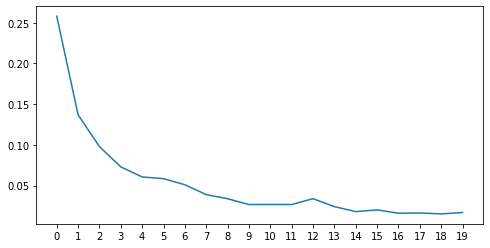

In [43]:
plt.figure(figsize=(8,4))
plt.xticks(np.arange(0,25,1))
plt.plot(range(len(lstm1)),lstm1);

In [0]:
 y_hat = model.predict(X)

In [45]:
y_hat[:, 0].shape

(142272,)

In [46]:
y[:, 0].shape

(142272,)

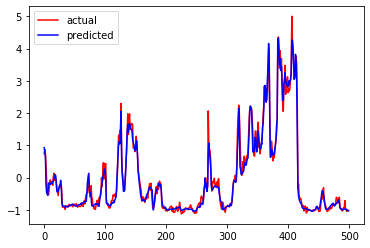

In [48]:
plt.plot(y[:500, 0], 'r-', label='actual')
plt.plot(y_hat[:500, 0], 'b-', label='predicted')
plt.legend()
plt.show()